In [1]:
%%capture
# Load the quadrotor simulator from a previous notebook
%run quadsim.ipynb

In [2]:
from IPython.core.display import HTML
HTML('<style>.impl-inner{background-color:#e4ffe6} .impl-outer{background-color:#e4ebff} .text_cell_render p { text-align: justify; text-justify: inter-word;}</style>')

# Sliding Mode Control

This discussion on sliding mode control for a multirotor closely follows the work of L'Afflitto et al. [1], in the notation of Khalil [2]. A diagram of the control scheme (taken from [1]) is shown below. In sliding mode control, trajectories of the system are steered to a subspace of the state space (i.e., the sliding manifold) in finite time. Once on this sliding surface, the system can asymptotically converge to the origin without regard to matched uncertainties. In [1], the control architecture shown below is used with sliding mode control to design an autopilot that steers a quadrotor to a given location with a given yaw angle.

A more introductory implementation of SMC is found in the [notebook](smc_cranfield.ipynb) based on Shaik's work.

![Control Scheme Diagram](assets/smc_control_scheme.png)

## Theory - System Modeling

Consider a nonlinear system of the form [2, eq 14.1]
\begin{equation}\label{eq:general_nonlinear_sys}
\dot{x} = f(x) + B(x)[G(x)E(x)u + \delta(t,x,u)],\quad x \in \mathbb{R}^n, \ u \in \mathbb{R}^p
\end{equation}
where $f$, $B$, and $E$ are known, while $G$ and $\delta$ could be uncertain. We assume that $E(x)$ is a nonsingular matrix and that $G(x)$ is a diagonal matrix whose elements are positive and bounded away from zero.

Suppose that $f(0) = 0$ so that, in the absence of $\delta$, the origin is an open-loop equilibrium point. **Our goal is to design a state feedback control law to stabilize the origin for all uncertainties in $G$ and $\delta$.**

Given a diffeomorphism $T$, \eqref{eq:general_nonlinear_sys} can be written in *regular form* [2, eq 14.4] as:
\begin{align}
\dot\eta &= f_a(\eta, \xi) \label{eq:normal-eta} \\
\dot\xi  &= f_b(\eta, \xi) + G(x)E(x)u + \delta(t, x, u). \label{eq:normal-xi}
\end{align}

Note that a large class of mechanical systems may be written in regular form, with the kinematics captured by \eqref{eq:normal-eta} and the dynamics captured by \eqref{eq:normal-xi}. This is great because kinematics are typically assumed to be perfectly known, while the dynamics of a system are subject to modeling errors and uncertainties in the system's inertial properties [1].

## Practice - System Modeling
In keeping with the architecture in the above figure from [1], we will consider the <span class="impl-inner">inner loop</span> and the <span class="impl-outer">outer loop</span> as separate nonlinear systems, writing each in the form of \eqref{eq:general_nonlinear_sys} and creating two sliding mode controllers that work together to stabilize the system around trajectories.

<div class="impl-inner">

For the purposes of control, we consider the inner loop kinematics of a quadrotor to be
\begin{align}
\dot{r_z} &= v_z \\
\dot{\phi} &\approx p \\
\dot{\theta} &\approx q \\
\dot{\psi} &\approx r \\
\end{align}
where we have assumed small angles s.t. $\Gamma \approx I_{3 \times 3}$. The inner loop dynamics are
\begin{align}
\ddot{r_z} &= g - \frac{F}{m}\cos\phi\cos\theta \\
\dot\omega &= -I^{-1} (\omega \times I\omega + M).
\end{align}
<br>
In our specific case, we can express the quadrotor system in the form of \eqref{eq:general_nonlinear_sys} with the following definitions:
\begin{align}
x &\triangleq
\begin{bmatrix} x_1 & x_2 & x_3 & x_4 & x_5 & x_6 & x_7 & x_8 \end{bmatrix}^\top =
\begin{bmatrix} r_z & \phi & \theta & \psi & \dot{r}_z & p & q & r \end{bmatrix}^\top \\
u &\triangleq
\begin{bmatrix} u_1 & u_2 & u_3 & u_4 \end{bmatrix}^\top =
\begin{bmatrix} F & \tau_\phi & \tau_\theta & \tau_\psi \end{bmatrix}^\top.
\end{align}
<br>
Which evolves as
\begin{align}\label{eq:inner-loop-dynamics-ss}
\dot{x} =
\begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \\ \dot{x}_3 \\ \dot{x}_4 \\ \dot{x}_5 \\ \dot{x}_6 \\ \dot{x}_7 \\ \dot{x}_8 \end{bmatrix} =
\begin{bmatrix} \dot{r}_z \\ \dot\phi \\ \dot\theta \\ \dot\psi \\ \ddot{r}_z \\ \dot{p} \\ \dot{q} \\ \dot{r} \end{bmatrix} =
\begin{bmatrix}
    x_5 \\ x_6 \\ x_7 \\ x_8 \\
    g - \frac{u_1}{m}\cos x_2 \cos x_3 \\
    \frac{J_y - J_z}{J_x} x_7 x_8 + \frac{1}{J_x} u_2 \\
    \frac{J_z - J_x}{J_y} x_6 x_8 + \frac{1}{J_y} u_3 \\
    \frac{J_x - J_y}{J_z} x_6 x_7 + \frac{1}{J_z} u_4
\end{bmatrix}
\end{align}
<br>
In order to transform these inner-loop dynamics into the regular form, we must identify the certain and uncertain components. We can break up \eqref{eq:inner-loop-dynamics-ss} into
\begin{align}
\dot{x} =
\underbrace{\begin{bmatrix}
    x_5 \\ x_6 \\ x_7 \\ x_8 \\
    g \\
    \frac{J_y - J_z}{J_x} x_7 x_8 \\
    \frac{J_z - J_x}{J_y} x_6 x_8 \\
    \frac{J_x - J_y}{J_z} x_6 x_7
\end{bmatrix}}_{f(x)} +
\underbrace{\begin{bmatrix}
    0_{4\times 4} \\ \hdashline
    I_{4\times 4}
\end{bmatrix}}_{B(x)}
\left(
\underbrace{\begin{bmatrix}
\frac{\cos x_2\cos x_3}{m} &0&0&0 \\
0& \frac{1}{J_x} &0&0 \\
0&0& \frac{1}{J_y} &0 \\
0&0&0& \frac{1}{J_z}
\end{bmatrix}}_{G(x)}
\underbrace{\begin{bmatrix}
-1&0&0&0 \\
0&1&0&0 \\
0&0&1&0 \\
0&0&0&1
\end{bmatrix}}_{E(x)}
\underbrace{\begin{bmatrix}
u_1 \\ u_2 \\ u_3 \\ u_4
\end{bmatrix}}_{u} +
\underbrace{0_{4\times 1}}_{\delta(t, x, u)}
\right).
\end{align}
<br>
Note how $G(x)$ contains the mass and the inertia terms, which are likely to be uncertain.
<br>
<br>
We then use the identity diffeomorphism $T:D\to\mathbb{R}^{n=8}, x\mapsto x$ to transform this system into the regular form:
\begin{align} \label{eq:inner-regular-transform}
\eta &=
\begin{bmatrix} x_1 & x_2 & x_3 & x_4 \end{bmatrix}^\top =
\begin{bmatrix} r_z & \phi & \theta & \psi \end{bmatrix}^\top \in \mathbb{R}^{n-p=4} \\
\xi &=
\begin{bmatrix} x_5 & x_6 & x_7 & x_8 \end{bmatrix}^\top =
\begin{bmatrix} \dot{r_z} & p & q & r \end{bmatrix}^\top \in \mathbb{R}^{p=4},
\end{align}
<br>
which evolves as
<br>
\begin{align}
\dot\eta &=
\begin{bmatrix} \dot{x_1} \\ \dot{x_2} \\ \dot{x_3} \\ \dot{x_4} \end{bmatrix} =
\begin{bmatrix} x_5 \\ x_6 \\ x_7 \\ x_8 \end{bmatrix} = f_a(\eta, \xi) = \xi \\
\dot\xi &=
\begin{bmatrix} \dot{x_5} \\ \dot{x_6} \\ \dot{x_7} \\ \dot{x_8} \end{bmatrix} =
\underbrace{\begin{bmatrix}
    g \\
    \frac{J_y - J_z}{J_x} x_7 x_8 \\
    \frac{J_z - J_x}{J_y} x_6 x_8 \\
    \frac{J_x - J_y}{J_z} x_6 x_7
\end{bmatrix}}_{f_b(\eta,\xi)} +
\underbrace{\begin{bmatrix}
\frac{\cos x_2\cos x_3}{m} & 0_{1\times 3} \\
0_{3\times 1} & I^{-1}
\end{bmatrix}}_{G(x)}
\underbrace{\begin{bmatrix}
-1 & 0_{1\times 3} \\
0_{3\times 1} & I_{3\times 3}
\end{bmatrix}}_{E(x)}
\underbrace{\begin{bmatrix}
u_1 \\ u_2 \\ u_3 \\ u_4
\end{bmatrix}}_{u} +
\underbrace{0_{4\times 1}}_{\delta(t, x, u)}
\end{align}
</div>

<div class="impl-outer">

The outer loop kinematics are
$$
\begin{align}
\dot{r}_x &= v_x \\
\dot{r}_y &= v_y
\end{align}
$$
with dynamics
$$
\begin{align}
\ddot{r}_x &= -\frac{u_1}{m}\left( \cos\phi\sin\theta\cos\psi + \sin\phi\sin\psi \right) \\
\ddot{r}_y &= -\frac{u_1}{m}\left( \cos\phi\sin\theta\sin\psi - \sin\phi\cos\psi \right).
\end{align}
$$
<br>
Expressing the outer loop in state-space form yields
$$
\begin{align}
x &\triangleq
\begin{bmatrix} x_1 & x_2 & x_3 & x_4 \end{bmatrix}^\top =
\begin{bmatrix} r_x & r_y & \dot{r}_x & \dot{r}_y \end{bmatrix}^\top \\
u &\triangleq
\begin{bmatrix} d_1 & d_2 \end{bmatrix}^\top =
\begin{bmatrix} \theta^d & \phi^d \end{bmatrix}^\top.
\end{align}
$$
<br>
Using the small-angle approximation ($\cos\theta\approx 1$; $\sin\theta\approx\theta$), we can write the evolution of the state vector as
$$
\begin{align}\label{eq:outer-loop-dynamics-ss}
\dot{x} =
\begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \\ \dot{x}_3 \\ \dot{x}_4 \end{bmatrix} =
\begin{bmatrix} \dot{r}_x \\ \dot{r}_y \\ \ddot{r}_x \\ \ddot{r}_y \end{bmatrix} =
\begin{bmatrix}
    x_3 \\ x_4 \\
    -\frac{u_1}{m}\left( \cos\phi\sin\theta\cos\psi + \sin\phi\sin\psi \right) \\
    -\frac{u_1}{m}\left( \cos\phi\sin\theta\sin\psi - \sin\phi\cos\psi \right)
\end{bmatrix} \approx
\begin{bmatrix}
    x_3 \\ x_4 \\
    -\frac{u_1}{m}\left( \theta\cos\psi + \phi\sin\psi \right) \\
    -\frac{u_1}{m}\left( \theta\sin\psi - \phi\cos\psi \right)
\end{bmatrix}.
\end{align}
$$
<br>
Similar as with the inner loop, we break \eqref{eq:outer-loop-dynamics-ss} into certain and uncertain components so that it is of the form of \eqref{eq:general_nonlinear_sys}.
$$
\begin{align}
\dot{x} =
\underbrace{\begin{bmatrix}
    x_3 \\ x_4 \\ 0 \\ 0
\end{bmatrix}}_{f(x)} +
\underbrace{\begin{bmatrix}
    0_{2\times 2} \\ \hdashline
    I_{2\times 2}
\end{bmatrix}}_{B(x)}
\left(
\underbrace{\left( \frac{1}{m} I_{2\times 2} \right)}_{G(x)}
\underbrace{
\begin{bmatrix}-u_1&0\\0&u_1\end{bmatrix}
\begin{bmatrix}
\cos\psi&\sin\psi \\
-\sin\psi&\cos\psi
\end{bmatrix}
}_{E(x)}
\underbrace{\begin{bmatrix}
\theta^d \\ \phi^d
\end{bmatrix}}_{u} +
\underbrace{0_{4\times 1}}_{\delta(t, x, u)}
\right).
\end{align}
$$
<br>
Again using the identity diffeomorphism $T:D\to\mathbb{R}^{n=4}, x\mapsto x$, we transform the system into regular form:
$$
\begin{align}
\eta &=
\begin{bmatrix} x_1 & x_2 \end{bmatrix}^\top =
\begin{bmatrix} r_x & r_y \end{bmatrix}^\top \in \mathbb{R}^{n-p=2} \\
\xi &=
\begin{bmatrix} x_3 & x_4 \end{bmatrix}^\top =
\begin{bmatrix} \dot{r}_x & \dot{r}_y \end{bmatrix}^\top \in \mathbb{R}^{p=2},
\end{align}
$$
which evolves as
$$
\begin{align}
\dot\eta &=
\begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \end{bmatrix} =
\begin{bmatrix} x_3 \\ x_4 \end{bmatrix} = f_a(\eta, \xi) = \xi \\
\dot\xi &=
\begin{bmatrix} \dot{x}_3 \\ \dot{x}_4 \end{bmatrix} =
\underbrace{\begin{bmatrix} 0 \\ 0 \end{bmatrix}}_{f_b(\eta,\xi)} +
\underbrace{\left( \frac{1}{m} I_{2\times 2} \right)}_{G(x)}
\underbrace{
\begin{bmatrix}-u_1&0\\0&u_1\end{bmatrix}
\begin{bmatrix}
\cos\psi&\sin\psi \\
-\sin\psi&\cos\psi
\end{bmatrix}
}_{E(x)}
\underbrace{\begin{bmatrix}
\theta^d \\ \phi^d
\end{bmatrix}}_{u} +
\underbrace{0_{4\times 1}}_{\delta(t, x, u)}
\end{align}
$$
</div>

## Theory - Stabilization

Given a system modelled in regular form, a stabilizing sliding mode controller can be designed. 

> We start by selecting the sliding manifold to be $s = \xi - \phi(\eta) = 0$ so that when motion is restricted to the manifold, the reduced-order model $\dot\eta = f_a(\eta, \phi(\eta))$ has an asymptotically stable origin. The design of $\phi(\eta)$ amounts to solving a stabilization problem for the system $\dot\eta = f_a(\eta,\xi)$ with $\xi$ viewed as the control input. This stabilization problem may be solved using any other technique, such as backstepping, feedback linearzation, etc. Upon designing a stabilizing controller $\phi(\eta)$, we must design an input $u$ that steers trajectories of $\dot\xi$ to the manifold $s=0$ (i.e., steers $\xi$ to $\phi(\eta)$) in finite time and maintains it there for all future time.

<p style="text-align: right">Khalil, p. 564 [2]</p>

We can achieve this by inspecting the time-evolution of the manifold $s$, which is
$$
\begin{equation}\label{eq:general-sdot}
\dot{s} = f_b(\eta,\xi) - \frac{\partial\phi}{\partial\eta} f_a(\eta,\xi) + G(x)E(x)u + \delta(t,x,u)
\end{equation}
$$

The control is given by
$$
\begin{equation}\label{eq:general-smc-control}
u = E^{-1}(x)\left\{ -L(x)\left[ f_b(\eta,\xi) - \frac{\partial\phi}{\partial\eta} f_a(\eta,\xi) \right] + v \right\}
\end{equation}
$$
where
\begin{equation}
v = -\beta(x) \text{sgn}(s).
\end{equation}

If $\hat{G}(x)$ is an approximation of the uncertain matrix $G(x)$ and we have access to it, then we let $L(x) = \hat{G}^{-1}$. Otherwise, let $L(x)=0$ and there will be no continuous component to the control---it will rely soley on the switching characteristic of $v$.

## Practice - Inner Loop Stabilization
For the sake of notation and understanding, we will first design and implement a sliding mode controller to stabilize the <span class="impl-inner">inner loop</span> to the origin. With this implementation, we will be able to see how deviations from $\begin{bmatrix} r_x & \phi & \theta & \psi \end{bmatrix}^\top = \mathbf{0}$ are regulated back to $\mathbf{0}$.

<div class="impl-inner">
The inner loop control strategy for stabilization about the origin is defined as follows:
$$
\begin{equation}
s = \xi - \phi(\eta) = \xi + K_1\eta,
\end{equation}
$$
where $K_1$ is a positive-definite diagonal matrix. Therefore, $\frac{\partial\phi}{\partial\eta} = -K_1$. Rearranging the control in equation \eqref{eq:general-smc-control}, we have the expression [1, eq 23]
$$
\begin{equation}\label{eq:smc-control}
u =  u_{eq} + E^{-1}(x)v,
\end{equation}
$$
where
$$
u_{eq} = -E^{-1}L(x)\left[ f_b(\eta,\xi) - \frac{\partial\phi}{\partial\eta}f_a(\eta,\xi) \right]
$$
and
$$
v = -\beta(x)\text{sgn}(s).
$$
<br>
Given that we have estimates of the inertial properties of the quadrotor, we let $L(x)=\hat{G}^{-1}$. Using the definitions from our inner loop modeling above and plugging them in to \eqref{eq:smc-control}, we have
$$
\begin{equation}\label{eq:inner-stabilizing-control}
u = -
\underbrace{\begin{bmatrix} -1 & 0_{1\times 3} \\ 0_{3\times 1} & I_{3\times 3} \end{bmatrix}}_{E^{-1}(x)}
\underbrace{\begin{bmatrix} \frac{m}{\cos x_2\cos x_3} & 0_{1\times 3} \\ 0_{3\times 1} & J \end{bmatrix}}_{G^{-1}(x)}
\left\{
\underbrace{\begin{bmatrix}
g \\
\frac{J_y - J_z}{J_x} x_7 x_8 \\
\frac{J_z - J_x}{J_y} x_6 x_8 \\
\frac{J_x - J_y}{J_z} x_6 x_7
\end{bmatrix}}_{f_b(\eta,\xi)}
+ K_1\xi
\right\}
+
\underbrace{\begin{bmatrix} -1 & 0_{1\times 3} \\ 0_{3\times 1} & I_{3\times 3} \end{bmatrix}}_{E^{-1}(x)} v.
\end{equation}
$$
<br>
Simplifying and breaking up into the 4 individual control channels gives
$$
\begin{align}
u_1 &= \frac{m}{\cos\phi\cos\theta}\left[ g +k_{r_z}\dot{r}_z\right] + \beta_{r_z}\text{sgn}(s_{r_z}) \label{eq:shaik-u1} \\
u_2 &= -J_x\left[ \frac{J_y - J_z}{J_x} qr + k_\phi \dot{\phi}\right] - \beta_\phi \text{sgn}(s_\phi) \\
u_3 &= -J_y\left[ \frac{J_z - J_x}{J_y} pr + k_\theta \dot{\theta}\right] - \beta_\theta \text{sgn}(s_\theta) \\
u_4 &= -J_z\left[ \frac{J_x - J_y}{J_z} pq + k_\psi \dot{\psi}\right] - \beta_\psi \text{sgn}(s_\psi). \label{eq:shaik-u4}
\end{align}
$$
<br>
By plugging these control equations into \eqref{eq:general-sdot}, it can be verified that the known components are canceled and the switching component is left behind, which causes $\dot{V} = -c(x)\left|s\right| < 0$.
<br><br>
    Note one difference from <a href="smc_cranfield.ipynb">Shaik's SMC implementation</a> is that the switching component is <i>inside</i> the bracket. This would seem to minimize the analytical upper bound necessary to prove that the control is stable in the sense of Lyapunov, but doesn't seem to make a difference in practice.
<br><br>
Another difference between this and Shaik's implementation is that there are sign differences. This comes from how Shaik defined the tracking error. Instead of the more common $e \triangleq x - x^d$, he defined the error as $e \triangleq x^d - x$. This causes the sign of the surface to be flipped, which causes $\text{sgn}(-s) = -\text{sgn}(s)$.
</div>

In [3]:
class StabilizingSMC(Controller):
    """Sliding Mode Controller
    
    This implementation of SMC only performs stabilization
    of the inner loop. That means that there is no way
    for the inner loop to track a reference other than zero.
    
    This controller can be seen in action if the initial
    attitude and/or altitude state of the quadrotor is non-zero.
    
    Also note that this controller uses sgn(x) instead of sat(x).
    As a result of this, chattering in the control effort and in
    the state can be seen. This is addressed later in the notebook.
    
    Inertial quantities are deviated from the true simulation
    values so as to represent SMC's robustness to uncertainty.
    """
    def __init__(self):
        self.name = "SMC: Stabilized Inner Loop"
        
        # estimates of the physical properties of the quadrotor
        self.g = 9.8
        self.mass = 4
        self.I = np.diag(np.array([0.1, 0.1, 0.1]))
        
        # proportional control law \phi(\eta) that stabilizes the inner \dot\eta = f_a system
        self.K1 = np.diag(np.array([3,3,4,1]))
                   
    def inner(self, state):
        
        def fa(eta, xi):
            return xi

        def fb(eta, xi):
            # extract omega from xi
            omega = xi[1:4]

            r = np.zeros((4,1))
            r[0,0] = self.g
            r[1:4] = -np.linalg.inv(self.I).dot(np.cross(omega, self.I.dot(omega), axis=0))
            return r
        
        # Transform the system into the form of HK (14.4) and (14.5)
        eta = np.array([state.flatten()[[2, 6, 7, 8]]]).T # r_z, ph, th, ps
        xi = np.array([state.flatten()[[5, 9, 10, 11]]]).T # \dot{r_z}, p, q, r
        
        ph = eta.flatten()[1]
        th = eta.flatten()[2]
        ps = eta.flatten()[3]
        
        # Build the inv(E(x)) matrix
        Einv = np.diag(np.array([-1,1,1,1]))
        
        # Build the L(x) = inv(G(x)) matrix
        L = np.eye(4)
        L[0, 0] = self.mass/(np.cos(ph)*np.cos(th))
        L[1:4, 1:4] = self.I
        
        # continuous control to cancel known terms: equation (18) of [1].
        ueq = -Einv.dot(L.dot(fb(eta, xi) + self.K1.dot(fa(eta, xi))))
        
        # Build the matrix of sliding surfaces
        SS = xi + self.K1.dot(eta)
        
        # Gains
        Beta = np.diag(np.array([6,1,7,2]))
        
        # switching components of the control: equation (20) of [1]
        # (but with a boundary on the sliding surface to mitigate chattering)
        gamma = -Beta.dot(np.sign(SS))
        
        # equation (23) of [1]
        u = ueq + Einv.dot(gamma)
        
        return u
    
    def update(self, commanded, state, pkt, Ts):
        
        #
        # Inner Loop
        #
        
        u = self.inner(state)
        
        # actuator commands
        return u, commanded

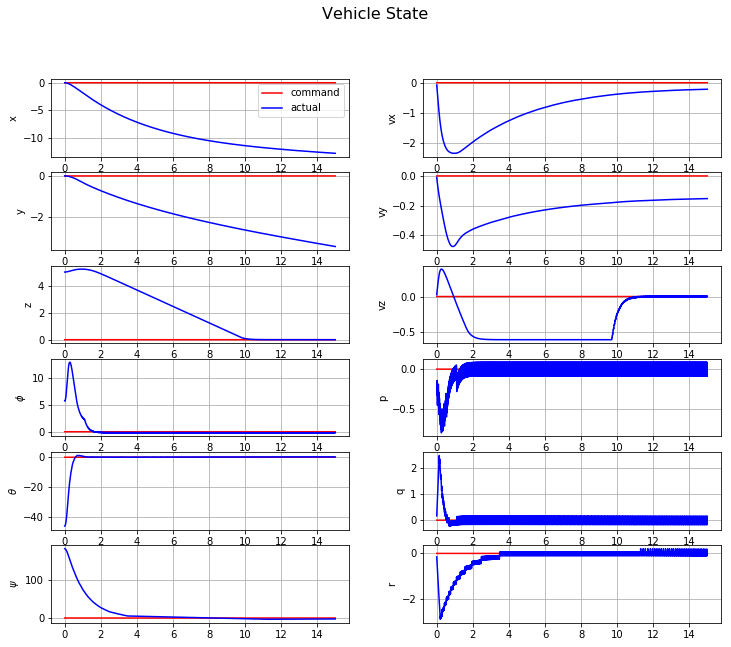

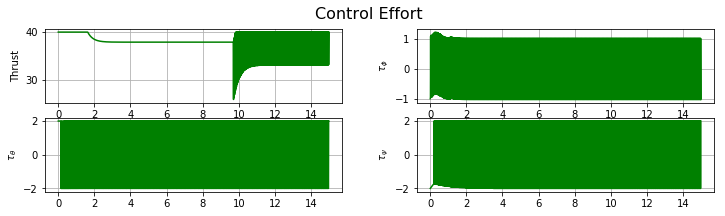

In [4]:
quad = Quadrotor(r=np.array([[0],[0],[5]]),
                 v=np.array([[0],[0],[0]]),
               Phi=np.array([[0.1],[-0.8],[3.15]]))
sim = Simulator(quad=quad, ctrl=StabilizingSMC())
sim.run(15, Ts=0.01)
sim.plot()

## Aside - Chattering
The discontinuous switching component $\text{sgn}(s)$ is used to maintain trajectories on the surface $s=0$. However, because there is uncertainty in every system, $s$ is typically always varying about $0$, causing the control to rapidly switch signs so that $s=0$ can be maintained. This creates an undesired effect known as chattering, which can be seen in the control effort from the inner loop stabilization controller above. To alleviate this, a margin is created around the surface $s=0$ so that the sensitivity is reduced and as long as trajectories are in the *neighborhood* of $s=0$ the control is successful. This can be implemented by replacing the signum function $\text{sgn}(s)$ with a saturation function, as shown below. The transition region can be controlled by scaling the surface by a variable $\epsilon$, such as $\text{sat}(\frac{s}{\epsilon})$, where $0.1 \le \epsilon \le 1$ is a typical range.

<table>
    <tr>
        <td><img src="assets/fig_sgn.svg" width="75%" /></td>
        <td><img src="assets/fig_sat.svg" width="75%" /></td>
    </tr>
</table>

A vectorized saturation function is implemented using `numpy` below:

In [5]:
def sat(v):
    v = np.copy(v)
    v[np.abs(v) > 1] = np.sign(v[np.abs(v) > 1])
    return v

## Theory - Tracking

In general, tracking a trajectory amounts to stabilizing the error between the current and the desired to zero. To this end, we rewrite the state-space representation as an error-state representation. Define the error as $\tilde{x_i} \triangleq x_i - x_i^d$, where $x_i^d$ is the desired reference value of $x_i$. The sliding surface must also be rewritten in terms of error. The vector of all reference signals is defined as $y$.

In this error representation, it is assumed that $y \in C^2$ and that $y$, $\dot y$, and $\ddot y$ are all available online. Given an arbitrary twice-differentiable signal, its derivative may numerically be computed using a [*dirty derivative*](utils.ipynb#Derivative-Filter).

## Practice - Tracking

We will redefine the state-space systems of the <span class="impl-inner">inner</span> and <span class="impl-outer">outer</span> loops to use the error-state representation.

<div class="impl-inner">

We start with the regular form of the inner loop, as written in equation \eqref{eq:inner-regular-transform}. Expressing as an error state, we have
$$
\begin{align}
\tilde\eta &= \eta - y =
\begin{bmatrix} \tilde{x}_1 & \tilde{x}_2 & \tilde{x}_3 & \tilde{x}_4 \end{bmatrix}^\top =
\begin{bmatrix} r_z-r_z^d & \phi-\phi^d & \theta-\theta^d & \psi-\psi^d \end{bmatrix}^\top \\
\tilde\xi &= \xi - \dot y =
\begin{bmatrix} \tilde{x}_5 & \tilde{x}_6 & \tilde{x}_7 & \tilde{x}_8 \end{bmatrix}^\top =
\begin{bmatrix} \dot{r}_z-\dot{r}_z^d & p-\dot\phi^d & q-\dot\theta^d & r-\dot\psi^d \end{bmatrix}^\top \\
y &= \begin{bmatrix} r_z^d & \phi^d & \theta^d & \psi^d \end{bmatrix}^\top
\end{align}
$$
<br>
which evolves as
<br>
$$
\begin{align}
\dot{\tilde\eta} &=
\begin{bmatrix} \dot{\tilde x}_1 \\ \dot{\tilde x}_2 \\ \dot{\tilde x}_3 \\ \dot{\tilde x}_4 \end{bmatrix} =
\begin{bmatrix} \tilde x_5 \\ \tilde x_6 \\ \tilde x_7 \\ \tilde x_8 \end{bmatrix} = f_a(\tilde\eta, \tilde\xi) = \tilde\xi \\
\dot{\tilde\xi} &=
\begin{bmatrix} \dot{\tilde x}_5 \\ \dot{\tilde x}_6 \\ \dot{\tilde x}_7 \\ \dot{\tilde x}_8 \end{bmatrix} =
\underbrace{\begin{bmatrix}
    g \\
    \frac{J_y - J_z}{J_x} qr \\
    \frac{J_z - J_x}{J_y} pr \\
    \frac{J_x - J_y}{J_z} pq
\end{bmatrix}}_{f_b(\eta,\xi)} -
\underbrace{\begin{bmatrix}
    \ddot{r}_z^d \\
    \ddot{\phi}^d \\
    \ddot{\theta}^d \\
    \ddot{\psi}^d
\end{bmatrix}}_{\ddot y} +
\underbrace{\begin{bmatrix}
\frac{\cos \phi\cos \theta}{m} & 0_{1\times 3} \\
0_{3\times 1} & J^{-1}
\end{bmatrix}}_{G(x)}
\underbrace{\begin{bmatrix}
-1 & 0_{1\times 3} \\
0_{3\times 1} & I_{3\times 3}
\end{bmatrix}}_{E(x)}
\underbrace{\begin{bmatrix}
u_1 \\ u_2 \\ u_3 \\ u_4
\end{bmatrix}}_{u}.
\end{align}
$$
<br>
Therefore, the new tracking control is very similar to the stabilizing control \eqref{eq:inner-stabilizing-control}, but with the subtraction of the reference signals $y$ and their first and second derivatives:
$$
\begin{equation}
u = -
\underbrace{\begin{bmatrix} -1 & 0_{1\times 3} \\ 0_{3\times 1} & I_{3\times 3} \end{bmatrix}}_{E^{-1}(x)}
\underbrace{\begin{bmatrix} \frac{m}{\cos \phi\cos \theta} & 0_{1\times 3} \\ 0_{3\times 1} & J \end{bmatrix}}_{G^{-1}(x)}
\left\{
\underbrace{\begin{bmatrix}
g \\
\frac{J_y - J_z}{J_x} qr \\
\frac{J_z - J_x}{J_y} pr \\
\frac{J_x - J_y}{J_z} pq
\end{bmatrix}}_{f_b(\eta,\xi)} -
\underbrace{\begin{bmatrix}
    \ddot{r}_z^d \\
    \ddot{\phi}^d \\
    \ddot{\theta}^d \\
    \ddot{\psi}^d
\end{bmatrix}}_{\ddot y}
+ K_1(\xi-\dot y)
\right\}
+
\underbrace{\begin{bmatrix} -1 & 0_{1\times 3} \\ 0_{3\times 1} & I_{3\times 3} \end{bmatrix}}_{E^{-1}(x)} v,
\end{equation}
$$
where
$$
\begin{equation}
v = -\beta(x)\text{sgn}(\tilde s)
\end{equation}
$$
and the sliding surface is redefined to be
$$
\begin{equation}
\tilde s = \tilde\xi + K_1\tilde\eta = (\xi-\dot y) + K_1(\eta-y).
\end{equation}
$$
</div>

<div class="impl-outer">

Following the same pattern as was done for the inner loop, the outer loop is rewritten in an error-state representation, with the reference signal defined as
$$
\begin{equation}
y = \begin{bmatrix} r_x^d & r_y^d \end{bmatrix}^\top.
\end{equation}
$$
<br>
The regular form of the error state,
$$
\begin{align}
\dot{\tilde\eta} &=
\begin{bmatrix} \dot{\tilde x}_1 \\ \dot{\tilde x}_2 \end{bmatrix} =
\begin{bmatrix} \tilde x_3 \\ \tilde x_4 \end{bmatrix} = f_a(\tilde\eta, \tilde\xi) = \tilde\xi \\
\dot{\tilde\xi} &=
\begin{bmatrix} \dot{\tilde x}_3 \\ \dot{\tilde x}_4 \end{bmatrix} =
\underbrace{\begin{bmatrix} 0 \\ 0 \end{bmatrix}}_{f_b(\eta,\xi)} -
\underbrace{\begin{bmatrix} \ddot{r}_x^d \\ \ddot{r}_y^d \end{bmatrix}}_{\ddot y} +
\underbrace{\left( \frac{1}{m} I_{2\times 2} \right)}_{G(x)}
\underbrace{
\begin{bmatrix}-u_1&0\\0&u_1\end{bmatrix}
\begin{bmatrix} \cos\psi&\sin\psi \\ -\sin\psi&\cos\psi \end{bmatrix}
}_{E(x)}
\underbrace{\begin{bmatrix}
\theta^d \\ \phi^d
\end{bmatrix}}_{u},
\end{align}
$$
leads to the tracking control
$$
\begin{equation}
u = -
\underbrace{
\begin{bmatrix} \cos\psi&-\sin\psi \\ \sin\psi&\cos\psi \end{bmatrix}
\begin{bmatrix}-\frac{1}{u_1}&0\\0&\frac{1}{u_1}\end{bmatrix}
}_{E^{-1}(x)}
\underbrace{\begin{bmatrix} m&0\\0&m \end{bmatrix}}_{G^{-1}(x)}
\left\{
\underbrace{\begin{bmatrix} 0\\0 \end{bmatrix}}_{f_b(\eta,\xi)} -
\underbrace{\begin{bmatrix} \ddot{r}_x^d \\ \ddot{r}_y^d \end{bmatrix}}_{\ddot y}
+ K_2(\xi-\dot y)
\right\}
+ E^{-1}(x) v,
\end{equation}
$$
where
$$
\begin{equation}
v = -\beta(x)\text{sgn}(\tilde s)
\end{equation}
$$
and the sliding surface is redefined to be
$$
\begin{equation}
\tilde s = \tilde\xi + K_2\tilde\eta = (\xi-\dot y) + K_2(\eta-y).
\end{equation}
$$
</div>

In [6]:
class SMC(Controller):
    """Sliding Mode Controller
    
    This implementation of SMC includes the ability
    to track reference signals, as opposed to the
    StabilizingSMC class above. In addition, this
    class utilizes a saturation function instead
    of the naive signum function for the switching
    component of the controller.
    """
    def __init__(self):
        self.name = "SMC"
        
        # dirty-derivative filters
        self.dyidt = DirtyDerivative(order=1, tau=0.0125)
        self.dyidt2 = DirtyDerivative(order=2, tau=0.025)
        self.dyodt = DirtyDerivative(order=1, tau=0.025)
        self.dyodt2 = DirtyDerivative(order=2, tau=0.05)
        
        # Value of total thrust from last iteration
        self.u1_d1 = 0
        
        # estimates of the physical properties of the quadrotor
        self.g = 9.81
        self.mass = 3.81
        self.I = np.diag(np.array([0.1, 0.1, 0.1]))
        
        # proportional control law \phi(\eta) that stabilizes the inner \dot\eta = f_a system
        self.K1 = np.diag(np.array([2,5,5,1]))
        
        # proportional control law \phi(\eta) that stabilizes the outer \dot\eta = f_a system
        self.K2 = np.diag(np.array([1,1]))
               
    def inner(self, desired, state, Ts):
        
        def fa(eta, xi):
            return xi

        def fb(eta, xi):
            # extract omega from xi
            omega = xi[1:4]

            r = np.zeros((4,1))
            r[0,0] = self.g
            r[1:4] = -np.linalg.inv(self.I).dot(np.cross(omega, self.I.dot(omega), axis=0))
            return r
        
        # Create the reference signal vector
        y = np.atleast_2d(desired).T # make a col vector
        ydot = self.dyidt.update(y, Ts)
        yddot = self.dyidt2.update(ydot, Ts)
        
        # Transform the system into the form of HK (14.4) and (14.5)
        eta = np.array([state.flatten()[[2, 6, 7, 8]]]).T # r_z, ph, th, ps
        xi = np.array([state.flatten()[[5, 9, 10, 11]]]).T # \dot{r_z}, p, q, r

        # for convenience
        ph = eta.flatten()[1]
        th = eta.flatten()[2]
        ps = eta.flatten()[3]
        
        # Build the inv(E(x)) matrix
        Einv = np.diag(np.array([-1,1,1,1]))
        
        # Build the L(x) = inv(G(x)) matrix
        L = np.eye(4)
        L[0, 0] = self.mass/(np.cos(ph)*np.cos(th))
        L[1:4, 1:4] = self.I
        
        # continuous control to cancel known terms: equation (18) of [1].
        ueq = -Einv.dot(L.dot( (fb(eta, xi) - yddot) + self.K1.dot( fa(eta-y, xi-ydot) )))
        
        # Build the matrix of sliding surfaces
        SS = (xi-ydot) + self.K1.dot(eta-y)
        
        # Gains
        Beta = np.diag(np.array([11,5,5,2]))
        
        # switching components of the control: equation (20) of [1]
        # (but with a boundary on the sliding surface to mitigate chattering)
        gamma = -Beta.dot(sat( SS/1 ))
        
        # equation (23) of [1]
        u = ueq + Einv.dot(gamma)
        
        return u
    
    def outer(self, desired, u1, state, Ts):
        
        # Make sure the thrust is non-zero
        if u1 == 0:
            return np.array([0,0])
        
        def fa(eta, xi):
            return xi

        def fb(eta, xi):
            return np.zeros((2,1))
        
        # Create the reference signal vector
        y = np.atleast_2d(desired).T # make a col vector
        ydot = self.dyodt.update(y, Ts)
        yddot = self.dyodt2.update(ydot, Ts)
                
        # Transform the system into the form of HK (14.4) and (14.5)
        eta = np.array([state.flatten()[[0, 1]]]).T # r_x, r_y
        xi = np.array([state.flatten()[[3, 4]]]).T # \dot{r}_x, \dot{r}_y
        
        ps = state.flatten()[8]
        
        # Build the inv(E(x)) matrix
        R = np.array([
            [ np.cos(ps), np.sin(ps)],
            [-np.sin(ps), np.cos(ps)],
        ])
        Einv = R.T.dot(np.diag(np.array([-1.0/u1,1.0/u1])))
        
        # Build the L(x) = inv(G(x)) matrix
        L = self.mass*np.eye(2)
        
        # continuous control to cancel known terms: equation (18) of [1].
        ueq = -Einv.dot(L.dot( (fb(eta, xi) - yddot) + self.K2.dot( fa(eta-y, xi-ydot) )))
        
        # Build the matrix of sliding surfaces
        SS = (xi-ydot) + self.K2.dot(eta-y)
        
        # Gains
        Beta = np.diag(np.array([15,15]))
        
        # switching components of the control: equation (20) of [1]
        # (but with a boundary on the sliding surface to mitigate chattering)
        gamma = -Beta.dot(sat(SS/1))
        
        # equation (23) of [1]
        u = ueq + Einv.dot(gamma)
        
        return u
    
    def update(self, commanded, state, pkt, Ts):
        
        #
        # Outer Loop
        #
        
        ref = self.outer(commanded.flatten()[[0, 1]], self.u1_d1, state, Ts)
        
        #
        # Inner Loop
        #
        
        # build reference signal for inner loop
        rz_ref = commanded.flatten()[2]
        ph_ref = ref.flatten()[1]
        th_ref = ref.flatten()[0]
        ps_ref = commanded.flatten()[8]
        desired = np.array([rz_ref, ph_ref, th_ref, ps_ref])
        
        u = self.inner(desired, state, Ts)

        # Save total thrust for the outer loop
        self.u1_d1 = u.flatten()[0]
        
        # update the commanded states
        commanded[6] = ph_ref
        commanded[7] = th_ref
        
        # actuator commands
        return u, commanded

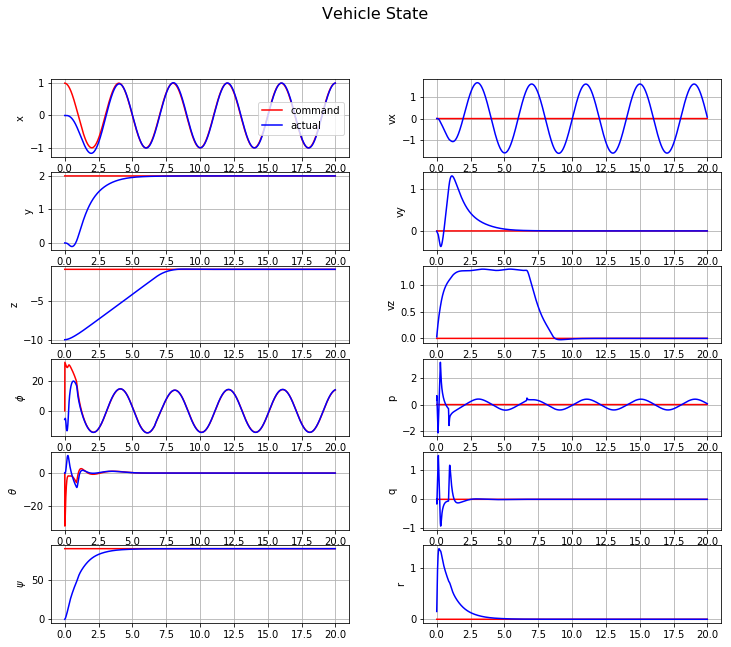

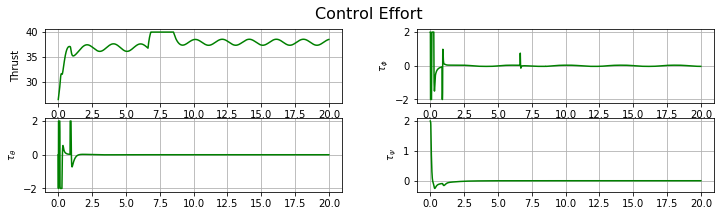

Quadrotor state after 2000 iters:
	r:     [[ 1.004  2.000 -1.000]].T
	Phi:   [[ 0.246  0.000  1.571]].T
	v:     [[ 0.065  0.000 -0.000]].T
	omega: [[ 0.063 -0.000  0.000]].T



In [15]:
# Instantiate a quadrotor model with the given initial conditions
quad = Quadrotor(r=np.array([[0],[0],[-10]]),
                 v=np.array([[0],[0],[0]]),
               Phi=np.array([[-0.1],[0],[0]]))

# Instantiate a tracking sliding mode controller
ctrl = SMC()

# Setup a setpoint commander
cmdr = Commander(default=True)
cmdr.attitude(np.array([0,0,np.pi/2]))

def set_position(i, Ts):
    f = 0.25
    x = np.cos(2*np.pi*f*i*Ts)
    return np.array([x, 2, -1])

cmdr.position(set_position)

# Run the simulation
sim = Simulator(quad, ctrl, cmdr=cmdr)
sim.run(20, Ts=0.01)
sim.plot()

## Conclusion

Sliding mode control is a fairly straightforward controller to implement with low computational demands (i.e., no optimization---it is all just linear algebra). Although there are various ways to approach the design of a sliding mode controller, the principle is the same:
<br><br>
1. Identify a sliding surface such as $s = \xi - \phi(\eta) = 0$ that you can drive system trajectories to. Once the system is on this manifold, it *slides* to the origin using the control law $\phi(\eta)$, which is typically designed to be linear (i.e., $\phi(\eta) = -K\eta$) but could be anything.
<br><br>
1. Choose $u$ to drive all system trajectories to the manifold $s=0$. While Khalil gives a general control form in equation \eqref{eq:general-smc-control}, the fundamental principle is Lyapunov stabiliy analysis. The control $u$ must be designed such that $\dot{V} = s\dot{s} < 0$. The control $u$ is often chosen with a continuous part that cancels any known terms from the model, and a discontinuous switching component $\beta(x)\text{sgn}(s)$ that guarantees a that the Lyapunov function is negative-definite in the direction of the system's trajectories.
<br><br>
1. Because $\text{sgn}(s)$ causes chattering, use $\text{sat}(\frac{s}{\epsilon})$ instead, where $\epsilon$ is typically small and can be tuned to change the transition region around the manifold $s=0$.

<br>

Other thoughts:
- Ensure that your derivatives are being computed corectly! For an $n$th-order derivative, make sure to wait until you have seen $n$ measurements.

## References

[1] A. L’Afflitto, R. Anderson, and K. Mohammadi, “An Introduction to Nonlinear Robust Control for Unmanned Quadrotor Aircraft,” IEEE Control Syst. Mag., vol. 38, no. June, pp. 102–121, 2018.

[2] H. K. Khalil, Nonlinear Systems. Princeton, NJ: Prentice Hall, 2002.

[3] M. K. Shaik and J. F. Whidborne, “Robust Sliding Mode Control of a Quadrotor,” 11th Int. Conf. Control, pp. 1–5, 2016.